In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.cluster import KMeans
from scipy.optimize import linear_sum_assignment
from cuml.manifold import TSNE

pd.set_option('display.max_columns',None)
np.random.seed(42)

## Load Dataset

In [57]:
dataset = pd.read_csv("../data/covtype.csv")

# make targets 0-indexed
dataset['Cover_Type'] -= 1

print(f'Dataset Shape: {dataset.shape}')
display(dataset.head())

Dataset Shape: (581012, 55)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,4
1,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,4
2,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
4,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,4


## Dataset Analysis

### Data Cleaning

In [58]:
# checking for duplicates and invalid entries
duplicate = dataset[dataset.duplicated()]
print("Duplicates:",duplicate.shape[0])
determine_na_cols = list(dataset.isna().sum())
na_cols = []
for i, val in enumerate(determine_na_cols):
    if val>0:
        na_cols.append(dataset.columns[i])
if len(na_cols)>0 : print("NA's found in", na_cols)
else: print("None of the datapoints have any N/A value.")

Duplicates: 0
None of the datapoints have any N/A value.


### Creating Splits

In [59]:
feature_labels = [l for l in dataset.columns if l != 'Cover_Type']
numerical_labels = [l for l in dataset.columns if 'Wilderness_Area' not in l and not 'Soil_Type' in l and l != 'Cover_Type']
categorical_labels = [l for l in dataset.columns if ('Wilderness_Area' in l or 'Soil_Type' in l) and l != 'Cover_Type']
target_labels = ['Cover_Type']

X_train, X_test, y_train, y_test = train_test_split(dataset[feature_labels], dataset[target_labels], test_size=0.20, stratify=dataset[target_labels])

### Dataset Stats

In our dataset, the categorical features are `Soil_Type` and `Wilderness_Area`. All other features are numerical.

In [60]:
display(X_train.describe())

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
count,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000
mean,2959.228419,155.566502,14.107218,269.431958,46.402811,2348.514160,212.165991,223.310508,142.490896,1979.935197,0.448416,0.051361,0.436517,0.063706,0.005170,0.013033,0.008375,0.021349,0.002773,0.011310,0.000189,0.000308,0.001949,0.056266,0.021417,0.051567,0.029978,0.001015,0.000006,0.004918,0.005820,0.003270,0.006932,0.015918,0.001424,0.057488,0.099645,0.036335,0.000809,0.004423,0.001859,0.001687,0.198208,0.051699,0.044371,0.090351,0.077834,0.002786,0.003201,0.000191,0.000506,0.026871,0.023754,0.014991
std,280.098983,111.873893,7.490359,212.639204,58.250424,1559.013623,26.773279,19.760641,38.284406,1324.431014,0.497333,0.220733,0.495954,0.244228,0.071716,0.113417,0.091134,0.144544,0.052588,0.105746,0.013758,0.017537,0.044107,0.230435,0.144771,0.221152,0.170527,0.031850,0.002541,0.069957,0.076064,0.057092,0.082969,0.125160,0.037712,0.232773,0.299527,0.187123,0.028430,0.066361,0.043074,0.041035,0.398650,0.221418,0.205918,0.286684,0.267911,0.052710,0.056490,0.013836,0.022480,0.161707,0.152281,0.121517
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1104.000000,198.000000,213.000000,119.000000,1022.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1994.000000,218.000000,226.000000,143.000000,1710.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00

As we can see above,

1. The mean elevation is 2959.365 m whereas the median elevation is 2996.
2. The median aspect is 127 degree azimuth and the median slope is 13 degrees.
3. The average horizontal distance to hydrology is 269.428 m and average vertical distance to hydrology is 46.418 m
4. The maximum elevation is 3858 m.
5. The average horizonatal distance to roadways is 2350.146 m, minimum distance is 0 m and the maximum distance is 7117 m.

#### TSNE Visualization

In [61]:
# # reduce dimensionality to 2D with TSNE
# tsne    = TSNE(n_components=2, perplexity=50, n_neighbors=200, learning_rate=20)
# tsne_2D = tsne.fit_transform(X_train)

# # tsne    = TSNE(n_components=2, perplexity=1000, n_neighbors=3000, learning_rate=20, n_iter=20000)
# # tsne_2D = tsne.fit_transform(dataset[feature_labels])

# # plot scatterplot
# fig = plt.figure(figsize=(18, 18))
# # fig.legend(dataset['Cover_Type'].unique())
# # plt.legend(dataset['Cover_Type'].unique())
# scatter = plt.scatter(tsne_2D[:,0], tsne_2D[:,1], c = X_train['Cover_Type'], s = 0.5)
# # plt.legend(handles=scatter.legend_elements()[0], labels=dataset['Cover_Type'].unique())

# # plot scatterplot
# X_embedded = pd.DataFrame({'tsne_x': tsne_2D[:, 0], 'tsne_y': tsne_2D[:, 1], 'Cover_Type': X_train['Cover_Type']})
# sns.scatterplot(data=X_embedded, x='tsne_x', y='tsne_y', hue='Cover_Type', style="Cover_Type")

### Correlation Study

<AxesSubplot: >

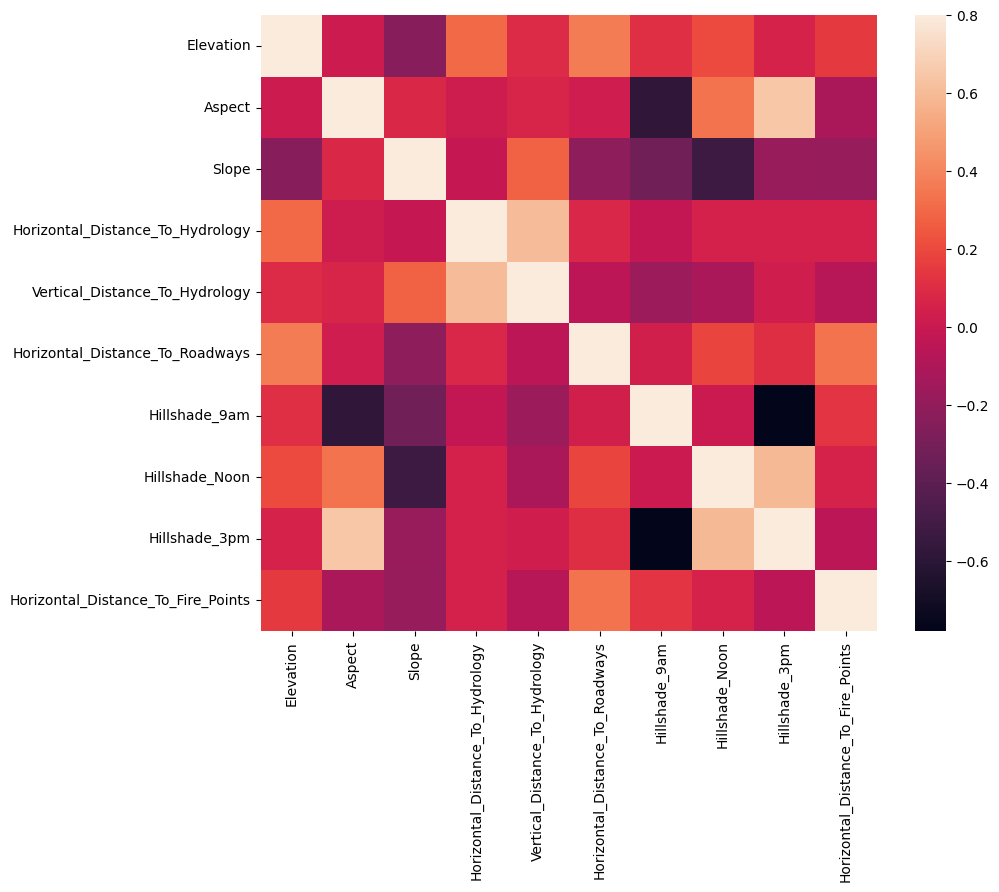

In [62]:
# checking correlations using Pearson's R
# TODO: check on categorical fields too
size = 10 
corrmatrix = X_train.iloc[:,:size].corr()
f, ax = plt.subplots(figsize=(10,8))
display(sns.heatmap(corrmatrix,vmax=0.8,square = True))
# display(corrmatrix)

Identifying highly correlated features;

In [63]:
high_corr_list = []
for i in range(0, size):
    for j in range(i+1, size):
        if abs(corrmatrix.iloc[i,j])>= 0.5:
            high_corr_list.append([corrmatrix.iloc[i,j],i,j])

# print the higher values
print("Correlation Values:")
cols = dataset.columns
for v,i,j in sorted(high_corr_list):
    print("\t", cols[i],"and", cols[j],f": {v: .2f}")

Correlation Values:
	 Hillshade_9am and Hillshade_3pm : -0.78
	 Aspect and Hillshade_9am : -0.58
	 Slope and Hillshade_Noon : -0.53
	 Hillshade_Noon and Hillshade_3pm :  0.59
	 Horizontal_Distance_To_Hydrology and Vertical_Distance_To_Hydrology :  0.61
	 Aspect and Hillshade_3pm :  0.65


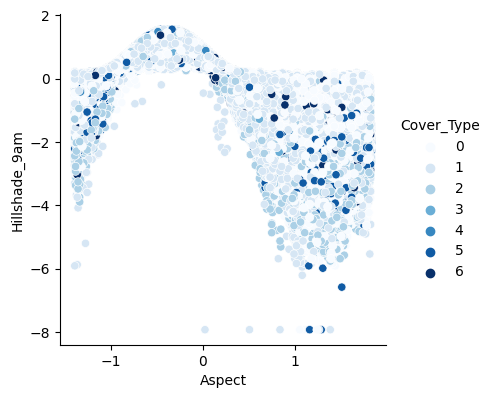

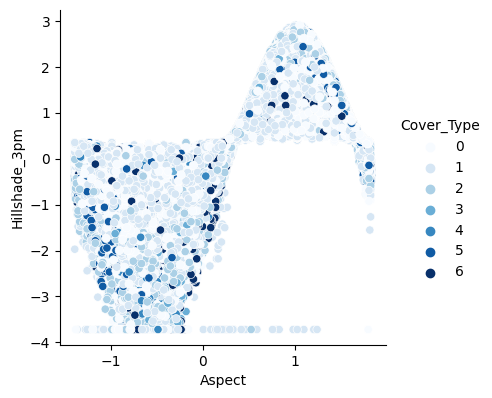

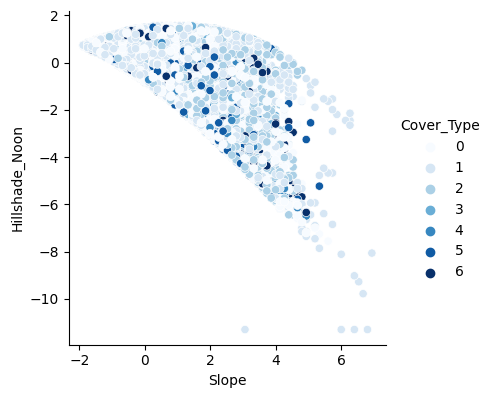

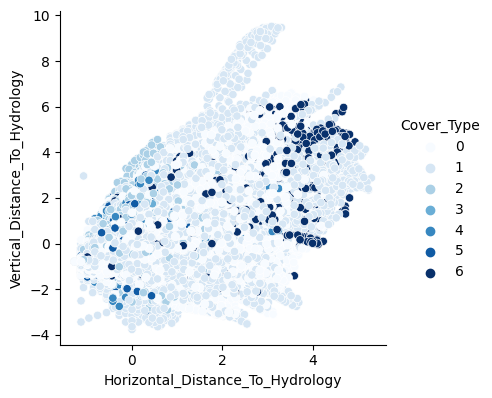

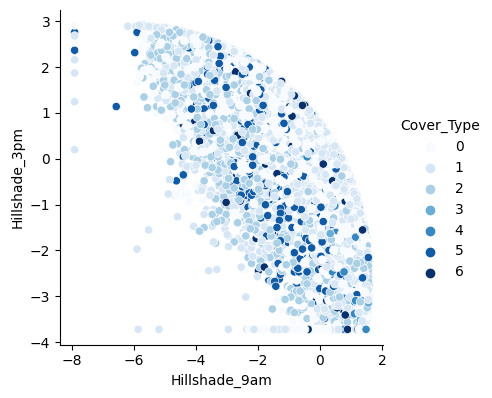

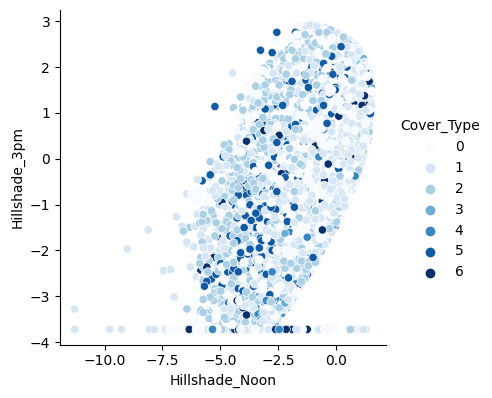

In [109]:
#Plotting a pair plot for the high correlated features
for v,i,j in high_corr_list:
    sns.pairplot(pd.concat([X_train,y_train],axis=1), hue="Cover_Type", height=4, palette = "Blues", x_vars=cols[i],y_vars=cols[j] )
    plt.show()

From the above graphs we can make the following inferences;
1. Hillshades have an ellipsoid pattern with each other
2. Hillshades and Aspect attributes show a sigmoid relationship

### Dataset Skew Study

In [64]:
# skew per label
skewness = X_train.iloc[:,:size].skew()
skew_score = {"high":[],"moderate":[],"fair":[]}
for i,skew in enumerate(skewness):
    if abs(skew)<=0.5:
        skew_score["fair"].append(cols[i])
    elif abs(skew)<=1:
        skew_score["moderate"].append(cols[i])
    else:
        skew_score["high"].append(cols[i])
for k in skew_score.keys(): print(f"{k}:{skew_score[k]}")

high:['Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Hillshade_9am', 'Hillshade_Noon', 'Horizontal_Distance_To_Fire_Points']
moderate:['Elevation', 'Slope', 'Horizontal_Distance_To_Roadways']
fair:['Aspect', 'Hillshade_3pm']


<AxesSubplot: xlabel='Cover_Type', ylabel='count'>

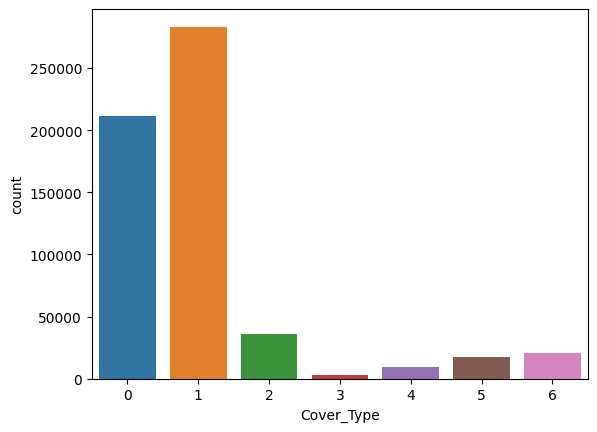

In [65]:
# skew in overall distribution of samples
plt.ylabel("# of Trees")
sns.countplot(data=dataset, x='Cover_Type')

### Standardization

In [66]:
scaler = StandardScaler()
X_train[numerical_labels] = scaler.fit_transform(X_train[numerical_labels])
X_test[numerical_labels] = scaler.transform(X_test[numerical_labels])

### Feature Engineering

In [69]:
# adding feature Euclidean_Distance_to_Hydrology
X_train["Euclidean_Distance_To_Hydrology"] = ((X_train['Horizontal_Distance_To_Hydrology']**2)+(X_train['Vertical_Distance_To_Hydrology']**2))**0.5
X_test["Euclidean_Distance_To_Hydrology"] = ((X_test['Horizontal_Distance_To_Hydrology']**2)+(X_test['Vertical_Distance_To_Hydrology']**2))**0.5
feature_labels.append("Euclidean_Distance_To_Hydrology")
numerical_labels.append("Euclidean_Distance_To_Hydrology")

## Modeling

### Unsupervised: KMeans

In [70]:
skf = StratifiedKFold(n_splits=5, shuffle=True)
skf.get_n_splits(X_train, y_train)

accuracies = []
for fold, (train_indices, val_indices) in enumerate(skf.split(X_train, y_train)):
    X_train_fold = X_train.iloc[train_indices].to_numpy()
    y_train_fold = y_train.iloc[train_indices].to_numpy()
    X_val_fold = X_train.iloc[val_indices].to_numpy()
    y_val_fold = y_train.iloc[val_indices].to_numpy()

    kmeans = KMeans(n_clusters=7)
    kmeans.fit(X_train_fold)

    clusters = kmeans.predict(X_val_fold)
    clusters_uniq, labels_uniq = np.unique(clusters), np.unique(y_train_fold)
    matrix = np.zeros((len(clusters_uniq),len(labels_uniq)))
    for cluster, y in zip(clusters, y_val_fold):
        matrix[cluster][y] += 1
    imap, jmap = linear_sum_assignment(matrix, maximize=True)
    accuracy = (matrix[imap, jmap].sum())/X_val_fold.shape[0]
    accuracies.append(accuracy)

    print(f'Fold {fold} validation accuracy: {accuracy}', end='\r')

print(f'Mean training accuracy: {np.mean(accuracies)}')

Mean training accuracy: 0.286470356512188169825


In [80]:
kmeans = KMeans(n_clusters=7)
kmeans.fit(X_train.to_numpy())

clusters = kmeans.predict(X_test.to_numpy())
clusters_uniq, labels_uniq = np.unique(clusters), np.unique(y_train)
matrix = np.zeros((len(clusters_uniq),len(labels_uniq)))
for cluster, y in zip(clusters, y_test.to_numpy()):
    matrix[cluster][y] += 1

imap, jmap = linear_sum_assignment(matrix, maximize=True)
accuracy = (matrix[imap, jmap].sum())/X_test.shape[0]
print(f'Test Accuracy: {accuracy}')

Test Accuracy: 0.28624045850795593


## Neural Network

In [98]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
ohe.fit(y_train.values)

In [99]:
X_train.shape, y_train_one_hot.shape

((464809, 55), (464809, 7))

In [100]:
import torch
from torch import nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score

torch.manual_seed(42)
# torch.use_deterministic_algorithms(False)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [101]:
# define model
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.dense_stack = nn.Sequential(
            nn.Linear(X_train.shape[1], 55**2),
            nn.ReLU(),
            nn.Linear(55**2, 55**2),
            nn.ReLU(),
            nn.Linear(55**2, 512),
            nn.ReLU(),
            nn.Linear(512, y_train_one_hot.shape[1])
        )

    def forward(self, x):
        logits = self.dense_stack(x)
        return logits

In [108]:
# training loop
BATCH_SIZE = 64
EPOCHS = 200
LR = 1e-3

skf = StratifiedKFold(n_splits=5, shuffle=True)
skf.get_n_splits(X_train, y_train)

accuracies = []
for fold, (train_indices, val_indices) in enumerate(skf.split(X_train, y_train)):
    X_train_fold = X_train.iloc[train_indices].to_numpy()
    y_train_fold = ohe.transform(y_train.iloc[train_indices].values).todense()
    X_val_fold = X_train.iloc[val_indices].to_numpy()
    y_val_fold = y_train.iloc[val_indices].to_numpy()

    # initialize model, loss and the optimizer
    model = Model().to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    prev_accuracy = float('inf')
    for epoch in range(EPOCHS):
        epoch_loss = 0
        for i in range(0, len(X_train_fold), BATCH_SIZE):
            X_batch = torch.Tensor(X_train_fold[i: i+BATCH_SIZE]).to(device)
            y_batch = torch.Tensor(y_train_fold[i: i+BATCH_SIZE]).to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            print(f"Fold {fold}, Epoch {epoch}, Batch Loss {loss.item()}", end='\r')

        with torch.no_grad():
            X_val_fold_tensor = torch.Tensor(X_val_fold).to(device)
            y_val_fold_tensor = torch.Tensor(ohe.transform(y_val_fold).todense()).to(device)

            outputs = model(X_val_fold_tensor)
            loss = criterion(outputs, y_val_fold_tensor)
            _, y_pred = torch.max(outputs, 1)
            f1 = f1_score(y_val_fold, y_pred.data.cpu(), average='weighted')
            ac = accuracy_score(y_val_fold, y_pred.data.cpu())
            if abs(ac-prev_accuracy)/prev_accuracy < 1e-5:
              accuracies.append(ac)
              break
        
        print(f"Fold {fold}, Epoch {epoch}, Epoch Loss {epoch_loss}, Val Loss {loss.item()}, Val F1 {f1}, Val Accuracy {ac}")

RuntimeError: false INTERNAL ASSERT FAILED at "../c10/cuda/CUDAGraphsC10Utils.h":73, please report a bug to PyTorch. Unknown CUDA graph CaptureStatus21968

In [ ]:
# test model on test split
with torch.no_grad():
  X_test_tensor = torch.Tensor(X_test.to_numpy()).to(device)
  y_test_tensor = torch.Tensor(ohe.transform(y_test.values).todense()).to(device)

  outputs = model(X_test_tensor)
  loss = criterion(outputs, y_test_tensor)
  _, y_pred = torch.max(outputs, 1)
  f1 = f1_score(y_test, y_pred.data.cpu(), average='weighted')
  ac = accuracy_score(y_test, y_pred.data.cpu())
  print(f1, ac)